# Variability

Investigate the differences in transcriptome variability between drugs that target the same system

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import itertools
import scipy.stats as stats

In [2]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento

In [3]:
import gseapy as gp
from gseapy.plot import gseaplot

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
data_path = '/data_volume/memento/sciplex/'

In [6]:
ct = 'A549'

In [7]:
adata = sc.read(data_path + 'h5ad/{}.h5ad'.format(ct))

### Define the drug classes

In [8]:
target_list = [
    'Aurora Kinase',
    'DNA/RNA Synthesis',
    'HDAC',
    'Histone Methyltransferase',
    'JAK',
    'PARP',
    'Sirtuin']

target_to_dir = {
    'Aurora Kinase':'aurora',
    'DNA/RNA Synthesis':'dna_rna',
    'HDAC':'hdac',
    'Histone Methyltransferase':'histmeth',
    'JAK':'jak',
    'PARP':'parp',
    'Sirtuin':'sirt'}

### Setup memento

In [16]:
adata.obs['q'] = 0.05

In [17]:
memento.setup_memento(adata, q_column='q', filter_mean_thresh=0.07)

Version 0.0.6


### control vs every dose in strata

In [18]:
target = 'HDAC'

In [19]:
drug_counts = adata.obs.query('target == "{}"'.format(target)).product_name.value_counts()
drug_list = drug_counts[drug_counts > 0].index.tolist()
num_drugs = len(drug_list)

In [43]:
names = ['Vehicle', 'Pracinostat (SB939)']
names = ['Vehicle', target]

In [44]:
subset = adata[adata.obs.target.isin(names)].copy().copy()

In [45]:
num_vehicle = (subset.obs.product_name =='Vehicle').sum()

In [46]:
subset.obs.loc[(subset.obs.product_name =='Vehicle'), 'dose'] = np.random.choice([10, 100, 1000, 10000], size=num_vehicle)
subset.obs['is_drug'] = (subset.obs.product_name != 'Vehicle').astype(int)

In [47]:
memento.create_groups(subset, label_columns=['is_drug', 'dose', 'product_name'])
memento.compute_1d_moments(subset, min_perc_group=.9)
memento.ht_1d_moments(
    subset, 
    formula_like='1 + is_drug + dose',
    treatment_col='is_drug', 
    num_boot=20000, 
    verbose=1,
    num_cpus=92,
    resampling='permutation',
    approx=False)

/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.6-py3.8.egg/memento/estimator.py:105: RuntimeWarning: invalid value encountered in log
[Parallel(n_jobs=92)]: Using backend LokyBackend with 92 concurrent workers.
[Parallel(n_jobs=92)]: Done  16 tasks      | elapsed:   19.9s
[Parallel(n_jobs=92)]: Done 266 tasks      | elapsed:  1.1min
[Parallel(n_jobs=92)]: Done 616 tasks      | elapsed:  2.2min
[Parallel(n_jobs=92)]: Done 1066 tasks      | elapsed:  3.7min
[Parallel(n_jobs=92)]: Done 1616 tasks      | elapsed:  5.4min
[Parallel(n_jobs=92)]: Done 2266 tasks      | elapsed:  7.5min
[Parallel(n_jobs=92)]: Done 2646 out of 2646 | elapsed: 13.4min finished


In [48]:
df = memento.get_1d_ht_result(subset)

In [49]:
df['dv_fdr'] = memento.util._fdrcorrect(df['dv_pval'])
df['de_fdr'] = memento.util._fdrcorrect(df['de_pval'])

In [51]:
df.query('dv_fdr < 0.1 & dv_coef > 0')

,gene,de_coef,de_se,de_pval,dv_coef,dv_se,dv_pval,dv_fdr,de_fdr
204,CDK13,-0.020637,0.025542,0.418229,0.585244,0.181340,0.003550,0.086592,0.545409
397,PTPN4,-0.022396,0.031843,0.484226,0.801631,0.192804,0.000577,0.047487,0.605225
646,PTGR1,0.014239,0.016555,0.392330,0.163575,0.042247,0.000232,0.038331,0.516985
745,PPFIBP1,0.174407,0.034516,0.000065,0.543060,0.177257,0.003450,0.086116,0.000762
776,NEDD9,0.127360,0.032424,0.000352,0.333715,0.109011,0.002800,0.078813,0.001772
791,PDE10A,-0.212641,0.015468,0.000049,0.209360,0.052853,0.000646,0.047487,0.000696
867,EHBP1,-0.067045,0.012958,0.000450,0.174201,0.051614,0.001050,0.053426,0.002085
930,CAMSAP2,0.025351,0.031042,0.414479,0.613346,0.197895,0.004750,0.098960,0.541782
1782,ABHD3,0.102728,0.033208,0.002050,0.391357,0.110909,0.000730,0.048107,0.006292
1918,ALDH1A1,-0.129698,0.011110,0.000106,0.129106,0.041844,0.001500,0.064013,0.000945


In [52]:
enr = gp.enrichr(gene_list=df.query('dv_fdr < 0.1').gene,
                 gene_sets=['GO_Biological_Process_2021'],
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )
enr.results.head(10)


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,positive regulation of protein localization to...,5/68,0.000075,0.099732,0,0,12.781649,121.412289,YAP1;WWTR1;TPR;FLNA;PSEN1
1,GO_Biological_Process_2021,unsaturated fatty acid metabolic process (GO:0...,4/54,0.000395,0.110855,0,0,12.788387,100.212405,EPHX1;PLA2G4A;PTGR1;MGLL
2,GO_Biological_Process_2021,actin filament organization (GO:0007015),6/152,0.000442,0.110855,0,0,6.644734,51.326433,MYO1D;HIP1;ELMO1;FLNA;NEDD9;ARHGAP17
3,GO_Biological_Process_2021,icosanoid metabolic process (GO:0006690),4/57,0.000486,0.110855,0,0,12.062690,92.021625,EPHX1;PLA2G4A;PTGR1;MGLL
4,GO_Biological_Process_2021,regulation of insulin secretion (GO:0050796),5/104,0.000550,0.110855,0,0,8.118995,60.933291,SNAP25;ITPR2;CACNA1D;CLOCK;SOX4
5,GO_Biological_Process_2021,cellular response to epidermal growth factor s...,3/28,0.000746,0.110855,0,0,19.053120,137.192948,MED1;GAREM1;SYAP1
6,GO_Biological_Process_2021,positive regulation of protein import into nuc...,3/28,0.000746,0.110855,0,0,19.053120,137.192948,TPR;FLNA;PSEN1
7,GO_Biological_Process_2021,purine-containing compound metabolic process (...,2/7,0.000836,0.110855,0,0,63.069841,446.990813,MACROD2;FHIT
8,GO_Biological_Process_2021,regulation of atrial cardiac muscle cell membr...,2/7,0.000836,0.110855,0,0,63.069841,446.990813,FLNA;CACNA1D
9,GO_Biological_Process_2021,glyceraldehyde-3-phosphate metabolic process (...,2/7,0.000836,0.110855,0,0,63.069841,446.990813,TPI1;ALDH1A1


In [53]:
enr = gp.enrichr(gene_list=df.query('dv_fdr < 0.1').gene,
                 gene_sets=['WikiPathways_2019_Human'],
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )
enr.results.head(10)


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,WikiPathways_2019_Human,DNA IR-Double Strand Breaks (DSBs) and cellula...,4/55,0.000424,0.041970,0,0,12.537002,97.357666,YAP1;PRKDC;SMC3;SMC1A
1,WikiPathways_2019_Human,Hypothesized Pathways in Pathogenesis of Cardi...,3/25,0.000531,0.041970,0,0,21.654545,163.280890,SERPINE1;FLNA;LTBP1
2,WikiPathways_2019_Human,MAPK Signaling Pathway WP382,7/246,0.001047,0.055143,0,0,4.752274,32.609161,TAOK1;AKT3;FLNA;PLA2G4A;CACNA1D;MAP3K5;FGFR1
3,WikiPathways_2019_Human,ATM Signaling Network in Development and Disea...,3/45,0.002986,0.090825,0,0,11.331429,65.878359,PRKDC;SMC1A;MAP3K5
4,WikiPathways_2019_Human,Glycolysis and Gluconeogenesis WP534,3/45,0.002986,0.090825,0,0,11.331429,65.878359,LDHB;TPI1;HK1
5,WikiPathways_2019_Human,H19 action Rb-E2F1 signaling and CDK-Beta-cate...,2/14,0.003517,0.090825,0,0,26.269841,148.430872,MED1;SOX4
6,WikiPathways_2019_Human,Regulation of sister chromatid separation at t...,2/15,0.004041,0.090825,0,0,24.247863,133.637768,SMC1A;SMC3
7,WikiPathways_2019_Human,Cori Cycle WP1946,2/16,0.004599,0.090825,0,0,22.514739,121.173687,TPI1;HK1
8,WikiPathways_2019_Human,Cell Cycle WP179,4/120,0.007428,0.130406,0,0,5.493882,26.933618,PRKDC;SMC3;SMC1A;CDC14B
9,WikiPathways_2019_Human,miRNA regulation of p53 pathway in prostate ca...,2/24,0.010230,0.161632,0,0,14.321789,65.628756,PERP;SERPINE1


In [ ]:
WikiPathways_2019_Human

### Summarize DE/DV

In [1]:
target = 'HDAC'

In [12]:
drug_counts = adata.obs.query('target == "{}"'.format(target)).product_name.value_counts()
drug_list = drug_counts[drug_counts > 0].index.tolist()
num_drugs = len(drug_list)

In [15]:
heatmap = pd.DataFrame(np.zeros((num_drugs, num_drugs)), index=drug_list, columns=drug_list)

In [50]:
for drug1, drug2 in itertools.combinations(drug_list,2):

    subset = sc.read(data_path + '{}/{}_vs_{}_stratified_perm.h5ad'.format(target_to_dir[target], drug1, drug2))
    df = memento.get_1d_ht_result(subset)
    df['dv_fdr'] = memento.util._fdrcorrect(df['dv_pval'])
    df['de_fdr'] = memento.util._fdrcorrect(df['de_pval'])
    
    print(drug1, drug2, df.query('dv_fdr < 0.1').shape[0], df.query('dv_fdr < 0.1').shape[0])
    
    break


TMP195 MC1568 0 0


(array([754., 414., 361., 304., 306., 305., 272., 295., 270., 339.]),
 array([2.08683897e-05, 1.00018782e-01, 2.00016695e-01, 3.00014608e-01,
        4.00012521e-01, 5.00010434e-01, 6.00008347e-01, 7.00006261e-01,
        8.00004174e-01, 9.00002087e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

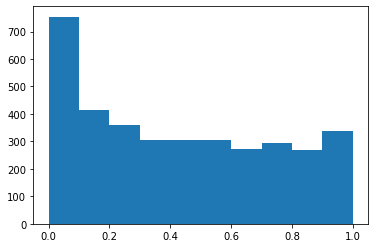

In [54]:
plt.hist(df['de_pval'])

In [41]:
def get_combined_1d_result(target, col='dv_pval'):
    
    drug_counts = adata.obs.query('target == "{}"'.format(target)).product_name.value_counts()
    drug_list = drug_counts[drug_counts > 0].index.tolist()

    result = pd.DataFrame()
    start = True
    for drug1, drug2 in itertools.combinations(drug_list,2):

        subset = sc.read(data_path + '{}/{}_vs_{}_10000.h5ad'.format(target_to_dir[target], drug1, drug2))
        df = memento.get_1d_ht_result(subset)
        df['dv_fdr'] = memento.util._fdrcorrect(df['dv_pval'])
        df['de_fdr'] = memento.util._fdrcorrect(df['de_pval'])
        if start:

            result['gene'] = df['gene']
            result['{}_{}'.format(drug1, drug2)] = df[col]
            start = False
        else:
            result = result.merge(df[['gene', col]].rename(columns={col:'{}_{}'.format(drug1, drug2)}), how='outer')
            
        result['num_sig'] = (result.iloc[:, 1:] < 0.1).sum()
            
    combined_pvals = []
    for g in result.gene:
        pvalues = result.query('gene == "{}"'.format(g)).iloc[0, 1:].values.astype(float)
        chisq, pv = stats.combine_pvalues(pvalues[np.isfinite(pvalues)])
        combined_pvals.append((g, chisq, pv))

    combined_pvals = pd.DataFrame(combined_pvals, columns=['gene', 'chisq', 'pv'])
    combined_pvals['fdr'] = memento.util._fdrcorrect(combined_pvals['pv'])
    
    return combined_pvals

In [42]:
target = 'HDAC'

In [43]:
combined_dv = get_combined_1d_result(target, col='dv_pval')

In [44]:
combined_de = get_combined_1d_result(target, col='de_pval')

In [45]:
combined_dv['bonf'] = combined_dv['pv']*combined_dv.shape[0]
combined_de['bonf'] = combined_de['pv']*combined_de.shape[0]

In [46]:
combined_dv.query('bonf < 0.001').sort_values('fdr').gene.shape

(1047,)

In [47]:
combined_de.query('bonf < 0.001').sort_values('fdr').gene.shape

(1178,)

In [48]:
enr = gp.enrichr(gene_list=combined_de.query('bonf < 0.001').sort_values('fdr').gene,
                 gene_sets=['GO_Biological_Process_2021'],
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )
enr.results.head(10)


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,cotranslational protein targeting to membrane ...,25/94,1.127410e-10,4.554738e-07,0,0,5.892945,134.983365,RPL10;RPL31;RPLP1;SRP54;RPS15;SEC61A1;RPS19;RP...
1,GO_Biological_Process_2021,"nuclear-transcribed mRNA catabolic process, no...",25/113,7.247859e-09,1.098131e-05,0,0,4.615923,86.514211,SMG1;RPL10;RPL31;RPLP1;PPP2R2A;RPS15;RPS19;PPP...
2,GO_Biological_Process_2021,SRP-dependent cotranslational protein targetin...,22/90,8.154435e-09,1.098131e-05,0,0,5.248677,97.755055,RPL10;RPL31;RPLP1;RPL23;SRP54;RPL13A;RPL35A;RP...
3,GO_Biological_Process_2021,cytoplasmic translation (GO:0002181),22/93,1.562292e-08,1.577915e-05,0,0,5.026098,90.341729,EIF4A1;RPL10;RPL31;RPLP1;RPL23;RPL13A;RPL35A;R...
4,GO_Biological_Process_2021,protein targeting to ER (GO:0045047),23/103,2.386483e-08,1.928278e-05,0,0,4.665216,81.878560,RPL10;RPL31;RPL23;RPLP1;SRP54;RPL13A;RPL35A;RP...
5,GO_Biological_Process_2021,cellular protein metabolic process (GO:0044267),54/417,4.323175e-08,2.910938e-05,0,0,2.443031,41.425722,APP;GALNT11;RPL31;PRKCSH;RPLP1;UBE2D2;MIA3;PRS...
6,GO_Biological_Process_2021,cellular protein modification process (GO:0006...,101/1025,2.119013e-07,1.222973e-04,0,0,1.816512,27.914599,APP;CCNT1;UBE2D2;PPP2R2A;PARK7;DCAF7;UBE2L3;CD...
7,GO_Biological_Process_2021,protein-containing complex assembly (GO:0065003),38/267,4.096964e-07,2.054482e-04,0,0,2.706405,39.805393,GSK3B;RAB1A;CDC123;CUL1;WASL;SPG7;TFG;PPP2R1A;...
8,GO_Biological_Process_2021,gene expression (GO:0010467),46/356,4.576816e-07,2.054482e-04,0,0,2.426627,35.421700,POM121;SMG1;NUP107;THRB;RPL10;RPL31;RPLP1;RPS1...
9,GO_Biological_Process_2021,nuclear-transcribed mRNA catabolic process (GO...,27/171,2.624013e-06,1.060101e-03,0,0,3.042680,39.100893,SMG1;RPL10;RPL31;RPLP1;PPP2R2A;RPS15;RPS19;PPP...


In [49]:
enr = gp.enrichr(gene_list=combined_dv.query('bonf < 0.001').sort_values('fdr').gene,
                 gene_sets=['GO_Biological_Process_2021'],
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )
enr.results.head(10)


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,cellular protein modification process (GO:0006...,98/1025,4.498231e-09,0.000017,0,0,2.008073,38.594323,ERO1A;CCNT1;UBE2D3;PLOD2;DCAF7;GOLGA2;RPS6KA5;...
1,GO_Biological_Process_2021,cellular response to DNA damage stimulus (GO:0...,43/350,1.828593e-07,0.000350,0,0,2.601250,40.357216,RPAIN;TRRAP;MCM8;USP10;ZBTB1;XIAP;SMC5;BRCA1;A...
2,GO_Biological_Process_2021,protein polyubiquitination (GO:0000209),39/314,5.108991e-07,0.000522,0,0,2.627857,38.070013,RNF34;PSMD14;FBXO28;UBE2D3;UBR2;BRCA1;RNF4;ANA...
3,GO_Biological_Process_2021,protein-containing complex assembly (GO:0065003),35/267,5.449554e-07,0.000522,0,0,2.790799,40.250474,KMT2D;RAB1A;TRRAP;WASL;GOLGA2;PPP6C;SCFD1;SNX9...
4,GO_Biological_Process_2021,organelle organization (GO:0006996),46/420,1.868648e-06,0.001371,0,0,2.282835,30.111265,RAB1A;MAST4;SH3KBP1;UBXN2A;PITPNB;ATL2;MIA3;NR...
5,GO_Biological_Process_2021,post-translational protein modification (GO:00...,40/345,2.148078e-06,0.001371,0,0,2.428639,31.696013,RAB1A;PSMD14;MIA3;PRSS23;LTBP1;DCAF7;PSMD5;PSM...
6,GO_Biological_Process_2021,gene expression (GO:0010467),40/356,4.667054e-06,0.002554,0,0,2.342715,28.756785,NUP205;POM121;SMG1;RPL36A;ADAR;SMG7;BICD1;SMG5...
7,GO_Biological_Process_2021,negative regulation of cellular macromolecule ...,54/547,5.831327e-06,0.002792,0,0,2.036242,24.541325,RB1;BRCA1;NR3C1;RPS6KA5;TRIM28;RACK1;EPC1;BTRC...
8,GO_Biological_Process_2021,DNA repair (GO:0006281),34/298,1.717308e-05,0.007030,0,0,2.376028,26.070180,RPAIN;TRRAP;ZBTB1;BRCC3;BRCA1;BACH1;ATXN3;BRIP...
9,GO_Biological_Process_2021,positive regulation of stress-activated protei...,7/18,2.019121e-05,0.007030,0,0,11.590385,125.295106,LYN;TGFB2;RNF13;TAOK3;ARL6IP5;MID1;KLHDC10


### GSEA + Enrichr

In [40]:
import gseapy as gp
from gseapy.plot import gseaplot


In [41]:
combined_pvals.query('fdr < 0.01').shape

(1050, 4)

In [46]:
enr = gp.enrichr(gene_list=combined_pvals.query('fdr < 0.005').sort_values('fdr').gene,
                 gene_sets=['GO_Biological_Process_2021'],
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )
enr.results.head(10)


In [47]:
enr.results.head(10)


,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Biological_Process_2021,nuclear-transcribed mRNA catabolic process (GO...,28/171,5.288169e-08,0.000200,0,0,3.679047,61.643208,SMG1;RPL32;RPL34;PARN;CASC3;RPL10A;RPL6;RPL7;S...
1,GO_Biological_Process_2021,"nuclear-transcribed mRNA catabolic process, no...",21/113,2.762529e-07,0.000521,0,0,4.270673,64.495482,UPF2;SMG1;RPL32;RPS7;RPL34;RPL23;RPS5;CASC3;RP...
2,GO_Biological_Process_2021,gene expression (GO:0010467),42/356,4.945169e-07,0.000622,0,0,2.525697,36.672322,POM121;SMG1;RPL32;RPL34;CASC3;RPL10A;BICD1;RPL...
3,GO_Biological_Process_2021,cellular protein modification process (GO:0006...,87/1025,2.836706e-06,0.002677,0,0,1.773571,22.653589,PRKCSH;UBE2D2;NGLY1;PRKAG1;PTEN;KEAP1;CHM;MIA3...
4,GO_Biological_Process_2021,cytoplasmic translation (GO:0002181),17/93,4.693658e-06,0.003544,0,0,4.172053,51.188160,EIF4A1;RPL32;RPS7;RPL34;RPL23;RPS5;RPL10A;RPL6...
5,GO_Biological_Process_2021,negative regulation of protein modification pr...,15/81,1.430557e-05,0.009001,0,0,4.232871,47.217086,G6PD;PRKAA1;CRTAP;TGFB1;YWHAB;NTRK3;PTEN;CDYL;...
6,GO_Biological_Process_2021,cotranslational protein targeting to membrane ...,16/94,2.263429e-05,0.012206,0,0,3.821777,40.877899,RPL32;RPS7;RPL34;RPL23;RPS5;SSR2;RPL10A;RPL6;R...
7,GO_Biological_Process_2021,organelle assembly (GO:0070925),42/425,4.193574e-05,0.017905,0,0,2.063017,20.793919,DDX6;ASAP1;AMBRA1;FNBP1L;LIMD1;BICD1;CDC14B;PC...
8,GO_Biological_Process_2021,phosphorylation (GO:0016310),40/400,4.874394e-05,0.017905,0,0,2.088664,20.738202,PRKAA1;PANK2;CAMK2D;ROCK1;PRKAG1;PIK3CB;LIMD1;...
9,GO_Biological_Process_2021,protein stabilization (GO:0050821),23/179,4.938509e-05,0.017905,0,0,2.754577,27.314005,CCT2;CRTAP;HSP90AA1;COG7;HIP1;RPS7;RPL23;PTGES...


In [48]:
enr = gp.enrichr(gene_list=combined_pvals.query('fdr < 0.01').sort_values('fdr').gene,
                 gene_sets=['WikiPathways_2019_Human'],
                 organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                 outdir=None,
                 cutoff=0.5 # test dataset, use lower value from range(0,1)
                )

In [49]:
df = enr.results.sort_values('Odds Ratio', ascending=False)
df[df['Adjusted P-value'] < 0.1].head(30)

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
39,WikiPathways_2019_Human,Somatroph axis (GH) and its relationship to di...,3/6,0.002560,0.024962,0,0,18.096466,107.993773,PTEN;SIRT1;IGF1R
29,WikiPathways_2019_Human,Leptin and adiponectin WP3934,4/10,0.001229,0.015979,0,0,12.073932,80.912494,CPT1A;PRKAA1;PRKAG1;ACACA
46,WikiPathways_2019_Human,HIF1A and PPARG regulation of glycolysis WP2456,3/8,0.006622,0.054281,0,0,10.856734,54.472477,TPI1;PPARG;GAPDH
55,WikiPathways_2019_Human,Cytosine methylation WP3585,3/9,0.009548,0.064566,0,0,9.046800,42.080520,IDH1;TDG;TET3
27,WikiPathways_2019_Human,SREBF and miR33 in cholesterol and lipid homeo...,5/16,0.001061,0.014782,0,0,8.237930,56.415759,PRKAA1;HMGCS1;SIRT1;MED15;LDLR
26,WikiPathways_2019_Human,Cori Cycle WP1946,5/16,0.001061,0.014782,0,0,8.237930,56.415759,G6PD;TPI1;GAPDH;PFKP;HK1
17,WikiPathways_2019_Human,Hereditary leiomyomatosis and renal cell carci...,6/20,0.000423,0.009175,0,0,7.773399,60.376130,PRKAA1;PRKAG1;KEAP1;ACACB;ACACA;NFE2L2
35,WikiPathways_2019_Human,TGF-B Signaling in Thyroid Cells for Epithelia...,5/18,0.001907,0.020659,0,0,6.969820,43.646645,SMAD2;TGFB1;CDH1;ID1;MAPK1
34,WikiPathways_2019_Human,Inhibition of exosome biogenesis and secretion...,5/18,0.001907,0.020659,0,0,6.969820,43.646645,PDCD6IP;RRAS2;MAPK1;BRAF;RAB5A
72,WikiPathways_2019_Human,"NAD metabolism, sirtuins and aging WP3630",3/11,0.017336,0.091587,0,0,6.784384,27.510354,NAMPT;PPARG;SIRT1


### Run 1D test against log10(dosage) 

Use different drugs as strata

In [86]:
for target in target_list:
    
    print('Starting ', target, '...')
    
#     target = 'HDAC'
    
    subset = adata[((adata.obs.target==target)) | (adata.obs.vehicle)].copy().copy()
    subset.obs['dose_indicator'] = subset.obs.dose.apply(lambda x: {0:0.0 ,10:1.0, 100:2.0, 1000:3.0, 10000:1.0}[x])
    subset.obs['dose_level'] = 'dose_' + subset.obs['dose'].astype(str)

    memento.create_groups(subset, label_columns=['dose_indicator'])
    memento.compute_1d_moments(subset, min_perc_group=.9)
    memento.ht_1d_moments(
        subset, 
        formula_like='1 + dose_indicator',
        treatment_col='dose_indicator', 
        num_boot=20000, 
        verbose=0,
        num_cpus=92,
        resampling='permutation',
        approx=False)
    
    subset.write(data_path + 'dosage/{}.h5ad'.format(target_to_dir[target]))
    
#     break

Starting  Aurora Kinase ...


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
... storing 'dose_level' as categorical
... storing 'memento_group' as categorical


Starting  DNA/RNA Synthesis ...


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical


Starting  HDAC ...


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical


Starting  Histone Methyltransferase ...


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical


Starting  JAK ...


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical


Starting  PARP ...


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical


Starting  Sirtuin ...


... storing 'dose_level' as categorical
... storing 'memento_group' as categorical


### AK

In [87]:
for target in target_list:
    
#     target = 'DNA/RNA Synthesis'
#     target = 'PARP'
    subset = sc.read(data_path + 'dosage/{}.h5ad'.format(target_to_dir[target]))

    df = memento.get_1d_ht_result(subset)
    df['de_fdr'] = memento.util._fdrcorrect(df['de_pval'])
    
    df = df.query('de_fdr < 0.05')
    df['dv_fdr'] = memento.util._fdrcorrect(df['dv_pval'])

    
    print(target)
    
    if df.query('dv_fdr <0.1').shape[0] > 10:
        enr = gp.enrichr(gene_list=df.query('dv_fdr <0.1 & dv_coef < 0').sort_values('dv_coef', ascending=False).gene,
             gene_sets=['WikiPathways_2019_Human'],
             organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
             outdir=None,
             cutoff=0.5 # test dataset, use lower value from range(0,1)
                    )
        print(enr.results.sort_values('Adjusted P-value').head(10)[['Term', 'Adjusted P-value']])
        


Aurora Kinase
                                                 Term  Adjusted P-value
0                                 NRF2 pathway WP2884          0.216304
1   Corticotropin-releasing hormone signaling path...          0.216304
2   Transcription co-factors SKI and SKIL protein ...          0.285740
3   miRNA targets in ECM and membrane receptors WP...          0.318287
27                      Leptin and adiponectin WP3934          0.329234
26  Interleukin-1 Induced Activation of NF-kappa-B...          0.329234
25                        Vitamin D Metabolism WP1531          0.329234
24                        Genotoxicity pathway WP4286          0.329234
23          MECP2 and Associated Rett Syndrome WP3584          0.329234
22                    Ectoderm Differentiation WP2858          0.329234


In [ ]:
df.sort_values('dv_pval')

In [81]:
# df = memento.get_1d_ht_result(subset)

(array([115.,  96.,  70.,  75.,  62.,  57.,  68.,  58.,  58.,  73.,  66.,
         65.,  65.,  51.,  69.,  69.,  50.,  51.,  62.,  53.,  61.,  62.,
         59.,  64.,  70.,  60.,  63.,  58.,  63.,  59.,  58.,  65.,  57.,
         66.,  74.,  67.,  73.,  67.,  68.,  64.]),
 array([3.74988086e-04, 2.53606136e-02, 5.03462392e-02, 7.53318647e-02,
        1.00317490e-01, 1.25303116e-01, 1.50288741e-01, 1.75274367e-01,
        2.00259992e-01, 2.25245618e-01, 2.50231244e-01, 2.75216869e-01,
        3.00202495e-01, 3.25188120e-01, 3.50173746e-01, 3.75159371e-01,
        4.00144997e-01, 4.25130622e-01, 4.50116248e-01, 4.75101873e-01,
        5.00087499e-01, 5.25073125e-01, 5.50058750e-01, 5.75044376e-01,
        6.00030001e-01, 6.25015627e-01, 6.50001252e-01, 6.74986878e-01,
        6.99972503e-01, 7.24958129e-01, 7.49943755e-01, 7.74929380e-01,
        7.99915006e-01, 8.24900631e-01, 8.49886257e-01, 8.74871882e-01,
        8.99857508e-01, 9.24843133e-01, 9.49828759e-01, 9.74814384e-01,
      

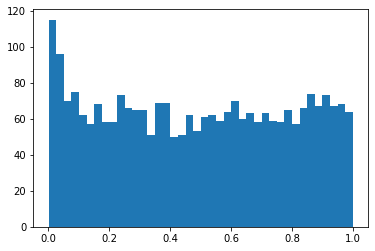

In [82]:
plt.hist(df.dv_pval, bins=40)